## Exploring the Evolution of Linux

Find out about the evolution of the Linux operating system by exploring its version control system.

#### Project Description

Version control repositories like CVS, Subversion or Git store rich evolution information about a software project. In this project, you'll be challenged to read in, clean up and visualize a real world Git repository dataset of the Linux kernel. With almost 700k commits and thousands of contributors (find out the exact number in this project ;-) ) there are some little data cleaning and wrangling challenges that you'll encounter. But you'll also gain insights about the development activities over the last 13 years.

For this Project, you need to be familiar with Pandas DataFrames, especially the read_csv and groupby functions, as well as working with time series data.

### Project Tasks

1. Introduction
2. Reading in the dataset
3. Getting an overview
4. Finding the TOP 10 contributors
5. Wrangling the data
6. Treating wrong timestamps
7. Grouping commits per year
8. Visualizing the history of Linux
9. Conclusion

In [49]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

### 1. Introduction

<p>Version control repositories like CVS, Subversion or Git can be a real gold mine for software developers. They contain every change to the source code including the date (the "when"), the responsible developer (the "who"), as well as a little message that describes the intention (the "what") of a change.</p>
<p>In this notebook, we will analyze the evolution of a very famous open-source project &ndash; the Linux kernel. The Linux kernel is the heart of some Linux distributions like Debian, Ubuntu or CentOS. Our dataset at hand contains the history of kernel development of almost 13 years (early 2005 - late 2017). We get some insights into the work of the development efforts by </p>
<ul>
<li>identifying the TOP 10 contributors and</li>
<li>visualizing the commits over the years.</li>
</ul>

In [2]:
# Importing & Printing the content of git_log_excerpt.csv
df = pd.read_csv('datasets/git_log_excerpt.csv', sep='#', names=['timestamp', 'name'])
# pd.to_datetime(df['timestamp'])
df

,timestamp,name
0,1502382966,Linus Torvalds
1,1501368308,Max Gurtovoy
2,1501625560,James Smart
3,1501625559,James Smart
4,1500568442,Martin Wilck
5,1502273719,Xin Long
6,1502278684,Nikolay Borisov
7,1502238384,Girish Moodalbail
8,1502228709,Florian Fainelli
9,1502223836,Jon Paul Maloy


### 2. Reading in the dataset
<p>The dataset was created by using the command <code>git log --encoding=latin-1 --pretty="%at#%aN"</code> in late 2017. The <code>latin-1</code> encoded text output was saved in a header-less CSV file. In this file, each row is a commit entry with the following information:</p>
<ul>
<li><code>timestamp</code>: the time of the commit as a UNIX timestamp in seconds since 1970-01-01 00:00:00 (Git log placeholder "<code>%at</code>")</li>
<li><code>author</code>: the name of the author that performed the commit (Git log placeholder "<code>%aN</code>")</li>
</ul>
<p>The columns are separated by the number sign <code>#</code>. The complete dataset is in the <code>datasets/</code> directory. It is a <code>gz</code>-compressed csv file named <code>git_log.gz</code>.</p>

In [3]:

# Reading in the log file
git_log = pd.read_csv('datasets/git.csv', sep='#', names=['time', 'names'])

# Printing out the first 5 rows
git_log.head()

,time,names
0,1502826583,Linus Torvalds
1,1501749089,Adrian Hunter
2,1501749088,Adrian Hunter
3,1501882480,Kees Cook
4,1497271395,Rob Clark


### 3. Getting an overview
<p>The dataset contains the information about every single code contribution (a "commit") to the Linux kernel over the last 13 years. We'll first take a look at the number of authors and their commits to the repository.</p>

In [4]:
len(git_log['names'].unique())

17383

In [5]:
# calculating number of commits
number_of_commits = len(git_log['time'])

# calculating number of authors
number_of_authors = len(git_log['names'].unique())

# printing out the results
print("%s authors committed %s code changes." % (number_of_authors, number_of_commits))

17383 authors committed 699071 code changes.


### 4. Finding the TOP 10 contributors
<p>There are some very important people that changed the Linux kernel very often. To see if there are any bottlenecks, we take a look at the TOP 10 authors with the most commits.</p>

In [6]:
# Identifying the top 10 authors
top_10_authors = git_log['names'].value_counts(ascending=False)
# Listing contents of 'top_10_authors'
top_10_authors.head(10)

Linus Torvalds           23361
David S. Miller           9106
Mark Brown                6802
Takashi Iwai              6209
Al Viro                   6006
H Hartley Sweeten         5938
Ingo Molnar               5344
Mauro Carvalho Chehab     5204
Arnd Bergmann             4890
Greg Kroah-Hartman        4580
Name: names, dtype: int64

## OR

In [7]:
# Identifying the top 10 authors
top_10_authors = git_log.groupby('names').agg({'time':'count'})
top_10_authors.reset_index(level='names', drop=False, inplace=True)
top_10_authors.sort_values(by='time', ascending=False, inplace=True)
# Listing contents of 'top_10_authors'
top_10_authors.head(10)

,names,time
8603,Linus Torvalds,23361
3585,David S. Miller,9106
9255,Mark Brown,6802
14358,Takashi Iwai,6209
269,Al Viro,6006
5384,H Hartley Sweeten,5938
6078,Ingo Molnar,5344
9791,Mauro Carvalho Chehab,5204
1436,Arnd Bergmann,4890
5218,Greg Kroah-Hartman,4580


### 5. Wrangling the data
<p>For our analysis, we want to visualize the contributions over time. For this, we use the information in the <code>timestamp</code> column to create a time series-based column.</p>

In [58]:
# converting the timestamp column
git_log['timestamp'] = pd.to_datetime(git_log['time'], unit='s')

# summarizing the converted timestamp column
git_log['timestamp'].describe()

C:\Users\DELL\AppData\Local\Temp/ipykernel_13476/1737398243.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  git_log['timestamp'].describe()


count                  699071
unique                 668448
top       2008-09-04 05:30:19
freq                       99
first     1970-01-01 00:00:01
last      2037-04-25 08:08:26
Name: timestamp, dtype: object

### 6. Treating wrong timestamps
<p>As we can see from the results above, some contributors had their operating system's time incorrectly set when they committed to the repository. We'll clean up the <code>timestamp</code> column by dropping the rows with the incorrect timestamps.</p>

In [59]:
git_log.iloc[[-1],2 ], git_log.iloc[[0], 2] 

(699070   2005-04-16 22:20:36
 Name: timestamp, dtype: datetime64[ns],
 0   2017-08-15 19:49:43
 Name: timestamp, dtype: datetime64[ns])

In [71]:
first_commit_timestamp = git_log['timestamp'].iloc[-1]

# determining the last sensible commit timestamp
last_commit_timestamp = git_log['timestamp'].iloc[0]

# filtering out wrong timestamps
corrected_log = git_log[(git_log['timestamp'] >= first_commit_timestamp) & (git_log['timestamp'] <= last_commit_timestamp)]

# summarizing the corrected timestamp column
corrected_log['timestamp'].describe()

C:\Users\DELL\AppData\Local\Temp/ipykernel_13476/2523036991.py:10: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  corrected_log['timestamp'].describe()


count                  698568
unique                 667976
top       2008-09-04 05:30:19
freq                       99
first     2005-04-16 22:20:36
last      2017-08-15 19:49:43
Name: timestamp, dtype: object

### 7. Grouping commits per year
<p>To find out how the development activity has increased over time, we'll group the commits by year and count them up.</p>

In [87]:
commits_per_year = corrected_log.groupby(pd.Grouper(key='timestamp', freq='Y')).count()

In [92]:
# Counting the no. commits per year
commits_per_year.count()

# Listing the first rows
commits_per_year.head()

,time,names
timestamp,,
2005-12-31,16230,16229
2006-12-31,29255,29255
2007-12-31,33759,33759
2008-12-31,48847,48847
2009-12-31,52572,52572


### 8. Visualizing the history of Linux
<p>Finally, we'll make a plot out of these counts to better see how the development effort on Linux has increased over the the last few years. </p>

<AxesSubplot:xlabel='timestamp'>

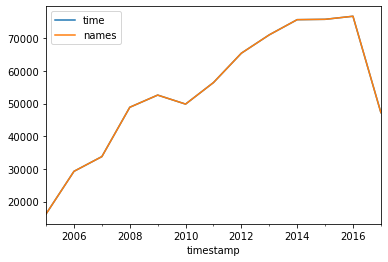

In [97]:
# Setting up plotting in Jupyter notebooks
%matplotlib inline

# plot the data
commits_per_year.plot(kind='line')

## 9.  Conclusion
<p>Thanks to the solid foundation and caretaking of Linux Torvalds, many other developers are now able to contribute to the Linux kernel as well. There is no decrease of development activity at sight!</p>

In [99]:
# calculating or setting the year with the most commits to Linux
year_with_most_commits = 2016

## Happy Learning :)